# Derived from https://keras.io/examples/lstm_text_generation/

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

DRIVE_DIR="/content/gdrive/My Drive/"

import os 
MODEL_DIR=os.path.join(DRIVE_DIR, "Colab Notebooks", "NYU", "Models")
modelDirExists = True if os.path.isdir(MODEL_DIR) else False

if modelDirExists:
  print("Saving checkpoints to ", MODEL_DIR)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Saving checkpoints to  /content/gdrive/My Drive/Colab Notebooks/NYU/Models


# Standard imports

In [4]:
import tensorflow as tf

from __future__ import print_function
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import get_file
import numpy as np
import random
import sys
import io

from tensorflow.keras.utils import plot_model
import IPython



# Get the text file
- create maps to map between characters and their integer encodings
  - from character to integer
  - from integer to character

In [5]:
path = get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


606208/600901 [==============================] - 1s 2us/step
corpus length: 600893
total chars: 57


# Prepare the training data: creating example sequences/targets
- example i: maxlen consecuitve characters
  - text[i:i+ maxlen] training example: $x^{(i)}$
  - text[maxlen] target: $y^{(i)}$


In [6]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))



nb sequences: 200285


# One Hot Encode the characters 
- in $x^{(i)},  y^{(i)}$

In [7]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1




Vectorization...


# Examine the input shape
- $x^{(i)}_{(t),j}$ is found at  $x[ i, t, j ]$

  - example i
  - time step/sequence element t
  - a sequence element is a vector, index at position j
    - length of OHE (number of distinct characters)

In [8]:
print("X shape: ", x.shape)
print("\tNumber of examples: ", x.shape[0])
print("\tEach example is sequence of length ", x.shape[1])
print("\tEach element of the sequence is of length ", x.shape[2])

X shape:  (200285, 40, 57)
	Number of examples:  200285
	Each example is sequence of length  40
	Each element of the sequence is of length  57


# Utility routines

The sample routine
- takes the probability vector (one probability per potential next character)
- uses it to randomly sample the next character to produce
- `temperature`
  - our model produces a probability from a score, using the softmax, as usual for Classifiers that we have studied
  - softmax exagerates small differences in the score into larger differences in probability
  - the `temperature` controls the degree of exageration
- the routine recalculates the probability, using the desired temperature before sampling



In [0]:
def createModel():
  model = Sequential()
  model.add(LSTM(128, input_shape=(maxlen, len(chars))))
  model.add(Dense(len(chars), activation='softmax'))

  return model

def plotModel(model, modelName):
  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)

  return plotFile
  
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()



Build model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


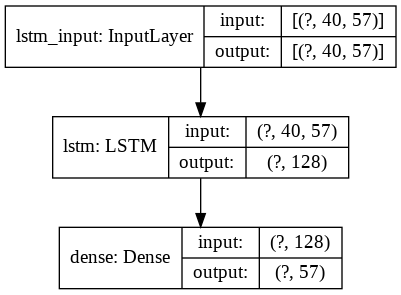

In [10]:
# build the model: a single LSTM
print('Build model...')
model = createModel()

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy') #, optimizer=optimizer)

plotFile = plotModel(model, "first_model")
IPython.display.Image(plotFile) 



# Resume training from existing weights ?

In [0]:
modelFile = os.path.join(MODEL_DIR, "lstm_text_gen-loss_1.2006.h5") # None

if modelFile is not None and os.path.exists(modelFile):
  model.load_weights(modelFile)

In [0]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

ckpt_filepath=os.path.join(MODEL_DIR, "lstm_text_gen-loss_{loss:.4f}.h5")
checkpoint_callback = ModelCheckpoint(ckpt_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')



# Train

In [0]:
callbacks = [print_callback]
if modelDirExists:
  callbacks.append(checkpoint_callback)

model.fit(x, y,
          batch_size=128,
          epochs=60,
          callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 200285 samples
Epoch 1/60
200192/200285 [============================>.] - ETA: 0s - loss: 1.1967
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "liar to her. alas, he who knows the hear"
liar to her. alas, he who knows the heart and the subject of the subject of the subject, and in the same dangerous and in the same and have still with any some destinction of the soul of the subject of all any of the soul of the subject of all the soul of the subjects and the subject of really it is a compelse of the state it is also the sort of the spectach sense of the serious and of the stands, the subject of self-destruction of the 
----- diversity: 0.5
----- Generating with seed: "liar to her. alas, he who knows the hear"
liar to her. alas, he who knows the heart of the most religion.


1-the same man would not the worstical something the truths and the dem